In [3]:
import pandas as pd

# Load dataset
file_path = "hotel_bookings.csv"  # Change this to your file path
df = pd.read_csv(file_path)

# Handle missing values
df['children'].fillna(0, inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['agent'].fillna(0, inplace=True)
df['company'].fillna(0, inplace=True)

# Convert date column to datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format='%d-%m-%y')

# Save cleaned dataset (optional)
df.to_csv("cleaned_hotel_bookings.csv", index=False)

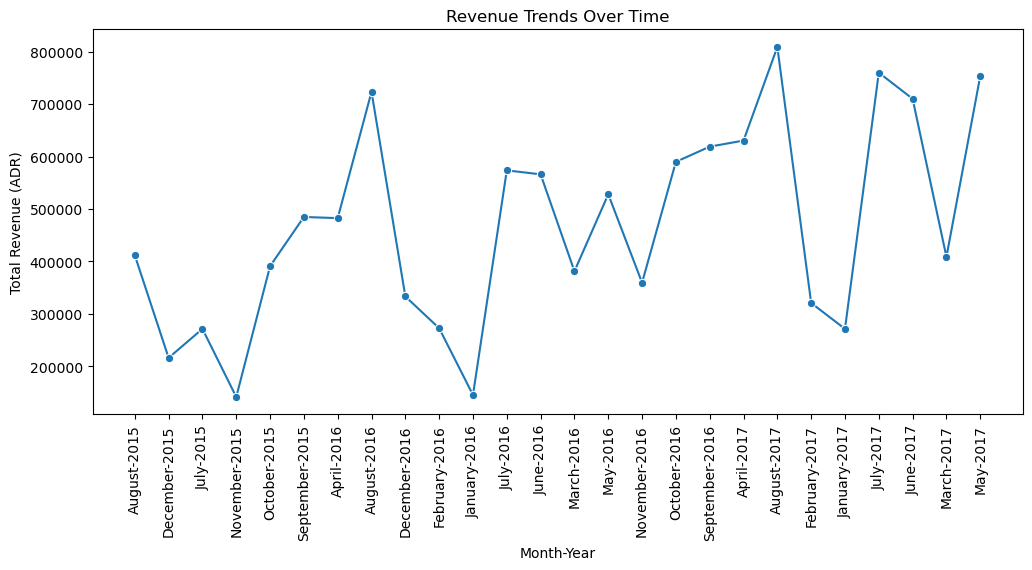

Cancellation Rate: 37.04%
Top 5 Booking Countries:
 PRT    40.698551
GBR    10.159142
FRA     8.723511
ESP     7.176480
DEU     6.103526
Name: country, dtype: float64


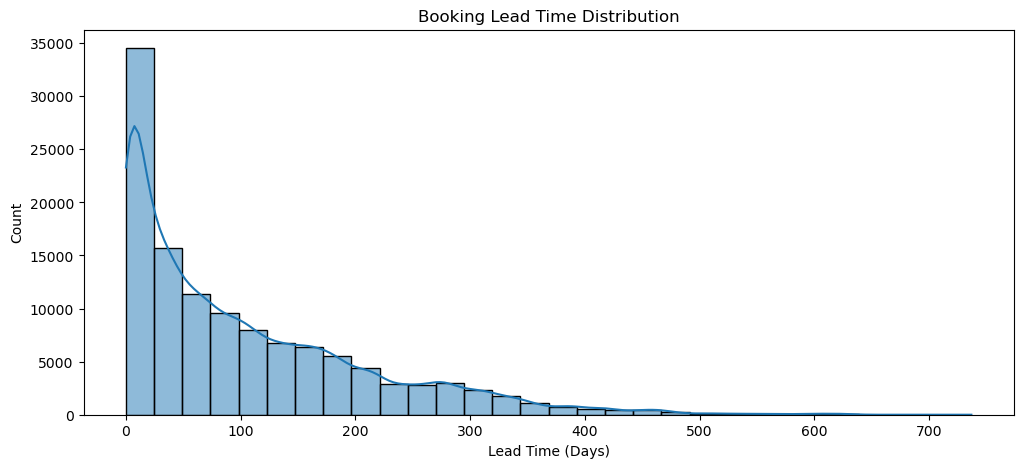

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Revenue Trends Over Time
df_revenue = df.groupby(['arrival_date_year', 'arrival_date_month'])['adr'].sum().reset_index()
df_revenue['date'] = df_revenue['arrival_date_month'] + '-' + df_revenue['arrival_date_year'].astype(str)
df_revenue.sort_values(by=['arrival_date_year', 'arrival_date_month'], inplace=True)

plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='adr', data=df_revenue, marker='o')
plt.xticks(rotation=90)
plt.xlabel('Month-Year')
plt.ylabel('Total Revenue (ADR)')
plt.title('Revenue Trends Over Time')
plt.show()

# Cancellation Rate
cancellation_rate = df['is_canceled'].mean() * 100
print(f"Cancellation Rate: {cancellation_rate:.2f}%")

# Geographical Distribution of Users
country_counts = df['country'].value_counts(normalize=True) * 100
print("Top 5 Booking Countries:\n", country_counts.head())

# Booking Lead Time Distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['lead_time'], bins=30, kde=True)
plt.xlabel('Lead Time (Days)')
plt.ylabel('Count')
plt.title('Booking Lead Time Distribution')
plt.show()

In [6]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Load a sentence transformer model for embedding
model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert booking data into a text format
df['text'] = df.apply(lambda row: f"Booking ID: {row.name}, Hotel: {row['hotel']}, Country: {row['country']}, Revenue: {row['adr']}, Lead Time: {row['lead_time']}", axis=1)

# Generate vector embeddings
embeddings = model.encode(df['text'].tolist(),show_progress_bar=True)

# Store embeddings in FAISS
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(np.array(embeddings))

# Query function
def ask_question(query):
    query_embedding = model.encode([query])
    _, indices = index.search(np.array(query_embedding), k=3)
    results = df.iloc[indices[0]]
    return results[['hotel', 'country', 'adr', 'lead_time']]

# Example
print(ask_question("Show me the highest revenue bookings"))

Batches:   0%|          | 0/3731 [00:00<?, ?it/s]

              hotel country     adr  lead_time
2013   Resort Hotel     GBR   55.43        100
20063  Resort Hotel     GBR   48.19        124
1603   Resort Hotel     PRT  197.00        155
